In [1]:
%pylab inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
from tensorflow.python.client import timeline
import json


Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()



class Simulation:
    
    def __init__(self, num_particles=1200, periodic_boundary=True, 
                 arena_size=1000.0, dt=1.5, social_weight=0.5, noise_stddiv=0.0,
                 body_size=1.5, draw_sim=True, state_threshold=0.5, num_active=600):
        
        self.dt = dt
        #self.periodic_boundary = tf.constant(periodic_boundary, tf.bool)
        self.periodic_boundary = periodic_boundary
        self.arena_size = arena_size
        self.num_particles = num_particles
        self.social_weight = social_weight
        self.noise_stddiv = noise_stddiv
        self.body_size = body_size
        self.draw_sim = draw_sim
        self.state_threshold = state_threshold
        self.num_active = num_active
        
        self.init_positions = np.random.rand(num_particles, 2) * arena_size   # initial position of particles
        self.init_velocities = self.generate_velocities()       # initial velocities of particles

        self.init_state = np.zeros((num_particles, 1), np.float32) 
        self.init_state[0:num_active] = 1
        
        self.graph = tf.Graph()
        self.main_graph()

    def generate_velocities(self):
        
        velocities = (np.random.standard_normal(size = (self.num_particles, 2))) 
        # make all velocities unit vectors
        velocities_mag = np.square(velocities)
        velocities_mag = np.sum(velocities_mag, 1)  
        velocities_mag = np.expand_dims(velocities_mag, 1)
        velocities_mag = np.tile(velocities_mag, (1, 2))
        velocities_mag = np.sqrt(velocities_mag)
        velocities = velocities / velocities_mag
        return velocities 

        
    def create_mask(self, r, inner_r, outer_r):
        """Return a mask that is true is distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m,2)
        """
        mask = tf.logical_and(tf.less(r, outer_r), tf.greater(r, inner_r))
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, 2)
        mask = tf.tile(mask,(1,1,2))
        mask = tf.cast(mask, tf.bool)
        return(mask)

    def create_mask_1d(self, r, inner_r, outer_r):
        """Return a mask that is true is distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m,1)
        """
        mask = tf.logical_and(tf.less(r, outer_r), tf.greater(r, inner_r))
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, 2)
        mask = tf.cast(mask, tf.bool)
        return(mask)

    def zone_vec_v(self, expanded_val, mask, zeros):
        """Apply mask to velocities calculate social alignment
        """
        vals = tf.tile(expanded_val, [1, self.num_particles, 1])
        #take term from vals where mask is true and from zeros when false
        vals = tf.where(mask, vals, zeros)
        return(tf.reduce_sum(vals, 0))

    def zone_vec_x(self, rel_pos, mask, zeros):
        #take term from rel_pos where mask is true and from zeros when false
        vals = tf.where(mask, rel_pos, zeros)
        return(tf.reduce_sum(vals, 0))

    def draw(self, window_size):
        visualization = np.zeros((window_size, window_size, 3), np.uint8)
        Cord=(np.array(self.init_positions)).astype(int) # Tranfer particles cordinates to numpy array format to use in plotting functin

        for i in xrange(len(Cord[:,0])):
            if self.init_state[i] == 0:
                cv2.circle(visualization,tuple(Cord[i,:]), 
                           int(self.body_size * window_size / window_size), 
                           (255,101,105),-1)
            else:
                cv2.circle(visualization,tuple(Cord[i,:]), 
                           int(self.body_size * window_size / window_size), 
                           (55,101,255),-1)

        cv2.imshow("visualization", visualization)
        cv2.waitKey(1)
        
    def main_graph(self):
        with self.graph.as_default():
            #---------------------Placeholders input parametes for the graph---------------------------------------------
            self.x = tf.placeholder(dtype=tf.float32, shape=(self.num_particles, 2))   # Position of particles in the begining of simulation step (input)
            self.v = tf.placeholder(dtype=tf.float32, shape=(self.num_particles, 2))   # Velocities of particles  in the begining of simulation step (input)
            self.state = tf.placeholder(dtype=tf.float32, shape=(self.num_particles, 1))

            expanded_x1 = tf.expand_dims(self.x, 0)  
            expanded_v1 = tf.expand_dims(self.v, 0)
            expanded_state1 = tf.expand_dims(self.state, 0)

            #periodic boundaries
            if self.periodic_boundary: 
                CellPos = [] #Will hold all the neighboring cells 
                for inx_1 in range(-1, 2): #Iterates over the neighboring cells
                    for inx_2 in range(-1, 2):
                        CellPos.append([inx_1*self.arena_size, inx_2*self.arena_size]) # (0,0) position of each of the neighbouring cells (top left corner)
                AllParticles = tf.expand_dims(CellPos, 1)  + expanded_x1  #Add particle position info to the neighbor cells
                AllParticles = tf.reshape(AllParticles,[-1, 2]) # Reshape to single array of particles coordinates
                expanded_x2 = tf.expand_dims(AllParticles, 1)
                AllParticlesV = tf.tile(expanded_v1, [1, 9, 1])
                AllParticlesV = tf.reshape(AllParticlesV,[-1, 2])
                expanded_v2 = tf.expand_dims(AllParticlesV, 1)
                AllParticlesState = tf.tile(expanded_state1, [1, 9, 1])
                AllParticlesState = tf.reshape(AllParticlesState,[-1, 1])
                expanded_state2 = tf.expand_dims(AllParticlesState, 1)

            else:
                expanded_x2 = tf.expand_dims(self.x, 1)
                expanded_v2 = tf.expand_dims(self.v, 1)
                expanded_state2 = tf.expand_dims(self.state, 1)

            #distance based calculations

            rx=tf.subtract(expanded_x1,expanded_x2 )#Distance between every pair of particles in x in every dimension (dx,dy)
            rx2=tf.square(rx) # sqar distane for each particle pair in each dimension  (dx^2,dx^2)
            r2=tf.reduce_sum(rx2,2) # absolute squar distance between every pair of particles(dx^2+dx^2)
            r=tf.sqrt(r2) # absolute distance between every pair of particles
            r=tf.maximum(r,tf.ones_like(r)*0.0002)# To avoid division by zero make min distance larger then 0 this add to prevent simulation explosion if particles get too closed

            abs_r = tf.abs(r)

            zor_r = tf.constant(10.0 * self.body_size, dtype = tf.float32 ) # radius of zone of alignment
            zoo_r = tf.constant(30.0 * self.body_size, dtype = tf.float32) # radius of zone of alignment
            zoa_r = tf.constant(100.0 * self.body_size, dtype = tf.float32) # radius of zone of alignment

            zor_mask = self.create_mask(abs_r, 0.0, zor_r)
            zoo_mask = self.create_mask(abs_r, zor_r, zoo_r)
            zoa_mask = self.create_mask(abs_r, zoo_r, zoa_r)
            state_mask = self.create_mask_1d(abs_r, zor_r, zoo_r)

            if self.periodic_boundary:
                zeros = tf.zeros([self.num_particles * 9, self.num_particles, 2], tf.float32)
                zeros_state = tf.zeros([self.num_particles * 9, self.num_particles, 1], tf.float32)

            else:
                zeros = tf.zeros([self.num_particles, self.num_particles, 2], tf.float32)
                zeros_state = tf.zeros([self.num_particles, self.num_particles, 1], tf.float32)


            r_expanded = tf.expand_dims(r, 2)
            r_expanded = tf.tile(r_expanded, (1, 1, 2))
            r_unit = rx / r_expanded

            zor_x = self.zone_vec_x(r_unit, zor_mask, zeros)
            zoo_v = self.zone_vec_v(expanded_v2, zoo_mask, zeros)
            zoa_x = self.zone_vec_x(r_unit, zoa_mask, zeros)
            state_active = self.zone_vec_v(expanded_state2, state_mask, zeros_state)
            state_ones = self.zone_vec_v(tf.ones_like(expanded_state2),
                                    state_mask, zeros_state)

            zor_x = tf.multiply(zor_x, tf.constant(1.0))
            zoo_v = tf.multiply(zoo_v, tf.constant(3.0))  #3
            zoa_x = tf.multiply(zoa_x, tf.constant(-0.5))

            zor_sum = tf.reduce_sum(tf.abs(zor_x), 1)
            mask_zor_empty = tf.logical_not(tf.greater(zor_sum, tf.constant(0.0)))

            zoa_zoo = tf.multiply(tf.reduce_sum(zoa_x, 1), tf.reduce_sum(zoo_v,1))
            mask_both_zones = tf.greater(zoa_zoo, tf.constant(0.0))
            both_zones = tf.to_float(mask_both_zones)  #should be 0 if only one zone has individs, 1 if both
            both_zones_expanded = tf.expand_dims(both_zones, 1)
            both_zones_expanded = tf.tile(both_zones_expanded, (1,2))

            outer_zones_v = tf.to_float(tf.pow(.5, both_zones_expanded)) * (zoa_x + zoo_v) 

            #states
            state_active = tf.reduce_sum(state_active, 1)
            state_ones = tf.reduce_sum(state_ones, 1)
            state_fraction = state_active / state_ones

            ones_state = tf.ones_like(self.state)
            zeros_state = tf.zeros_like(self.state)
            state_new = tf.where(tf.less(state_fraction, self.state_threshold),
                                zeros_state, self.state)
            self.state_new = tf.where(tf.greater(state_fraction, self.state_threshold), 
                                      ones_state, state_new)

            vnew = tf.where(mask_zor_empty, outer_zones_v, zor_x)

            vnew = tf.minimum(vnew, tf.ones_like(vnew) * 100000.0) #so speed can't blow up

            personal_weight = 1 - self.social_weight
            vnew = self.social_weight*vnew + personal_weight*self.v
            noise = tf.random_normal(vnew.get_shape(), mean=0.0, stddev=self.noise_stddiv, dtype=tf.float32)
            vnew = vnew + noise

            vnew_mag = tf.square(vnew)
            vnew_mag = tf.reduce_sum(vnew_mag, 1) 
            vnew_mag = tf.sqrt(vnew_mag)
            vnew_mag = tf.expand_dims(vnew_mag, 1)
            vnew_mag = tf.tile(vnew_mag, (1, 2)) 
            self.vnew = vnew / vnew_mag

            self.xnew = self.x + self.vnew*self.dt

            #-----------if epetitive  boundary conditions are used make sure particle poistion dont exceed cell size-------------------------------------------------------------------
            if self.periodic_boundary:
                self.xnew=tf.mod(self.xnew + self.arena_size, self.arena_size)# repititive boundary conditions make sure the particle never exit the box

    #@property
    def run_sim(self):
        WITH_TIMER = False
        arena_size_int = int(self.arena_size)

        with tf.Session(graph=self.graph) as session: #Create graph session
            if WITH_TIMER:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            for i in range(100000):   
                if WITH_TIMER:
                    [self.init_positions, self.init_velocities, self.init_state] = (
                        session.run([self.xnew,self.vnew,self.state_new],feed_dict = {
                            self.x: self.init_positions, 
                            self.v: self.init_velocities,
                            self.state: self.init_state},  
                        options=run_options, run_metadata=run_metadata))


                    tl = timeline.Timeline(run_metadata.step_stats)
                    ctf = tl.generate_chrome_trace_format()

                    with open('timeline.json', 'w') as f:
                        f.write(ctf)
                else:
                    [self.init_positions, self.init_velocities, self.init_state] = (
                        session.run([self.xnew,self.vnew,self.state_new],feed_dict = {
                            self.x: self.init_positions, 
                            self.v: self.init_velocities,
                            self.state: self.init_state}))
            #----------------------Plot particles position real time---------------------------------------------       
                if (i%2==0) and (self.draw_sim==True):
                    self.draw(arena_size_int)
                    if cv2.waitKey(1) & 0xFF == 27:
                        break  #time delay
                sum_state = np.sum(self.init_state, 0) / self.num_particles
                if sum_state == 0 or sum_state == 1:
                    break
            session.close() 
        cv2.destroyAllWindows() 
        return sum_state[0]


In [3]:
results_df = pd.DataFrame()
number_of_conditions = 1
number_of_trials = 1
SAVE = False
#Warm things up
sim = Simulation(
    social_weight=0.0, draw_sim=False, state_threshold = 0.01 )
sim.run_sim()

for weight_count in [1.0]:
    social_weight = weight_count * 0.5
    for cond_count in range(number_of_conditions):
        num_active = 600
        print(cond_count, ' ', weight_count)
        for trial_count in range(number_of_trials): 
            print(trial_count)
            sim = Simulation(
                social_weight=social_weight, draw_sim=True, num_active = num_active, dt=1.5)
            if SAVE:
                t_start = time.time()
                index =  (weight_count * number_of_trials * number_of_conditions 
                          +number_of_trials * cond_count 
                          + trial_count)
                results_df.loc[index, 'end_state'] = sim.run_sim()
                results_df.loc[index, 'time'] = time.time() - t_start
                results_df.loc[index, 'social_weight'] = social_weight
                results_df.loc[index, 'num_active'] = num_active
            else:
                sim.run_sim()


(0, ' ', 1.0)
0


In [4]:
results_df

,end_state,time,social_weight,num_active
0.0,0.0,45.306695,0.0,600.0
1.0,1.0,93.650242,0.0,600.0
2.0,1.0,58.376476,0.0,600.0
3.0,0.0,35.206134,0.0,600.0
4.0,0.0,61.210199,0.0,600.0
5.0,0.0,49.001133,0.0,600.0
6.0,1.0,50.123609,0.0,600.0
7.0,1.0,44.917030,0.0,600.0
8.0,0.0,54.772667,0.0,600.0
9.0,0.0,19.879957,0.0,600.0


In [10]:
file_name = 'trials_20_num_active_600_social_2'
results_df.to_pickle(file_name)
processed_df = pd.read_pickle(file_name)
processed_df_0_0 = processed_df.loc[lambda df: df.social_weight == 0.0, :]
processed_df_0_5 = processed_df.loc[lambda df: df.social_weight == 0.5, :]
processed_df_0_0 = processed_df_0_0.groupby('num_active').sum()/20.0
processed_df_0_5 = processed_df_0_5.groupby('num_active').sum()/20.0
processed_df_0_0


,end_state,time,social_weight
num_active,,,
600.0,0.45,61.528092,0.0


num_active
600.0    61.528092
Name: time, dtype: float64


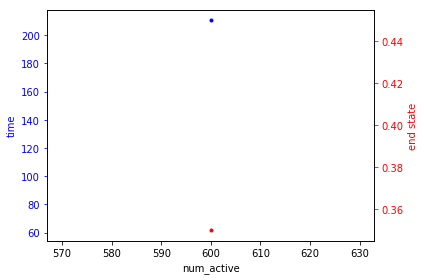

In [7]:
import matplotlib.pyplot as plt

print(processed_df_0_0['time'])
fig, ax1 = plt.subplots()
ax1.plot(processed_df_0_0['time'], 'b-')
ax1.plot(processed_df_0_5['time'], 'r-')
ax1.set_xlabel('num_active')
ax1.set_ylabel('time', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(processed_df_0_0['end_state'], 'b.')
ax2.plot(processed_df_0_5['end_state'], 'r.')
ax2.set_ylabel('end state', color='r')
ax2.tick_params('y', colors='r')



fig.tight_layout()
plt.show()

In [4]:
df = pd.DataFrame()
df['time'] = np.zeros(3)
df.loc[0, 'ones'] = 1
df.loc[1, 'ones'] = 0
df.loc[2, 'ones'] = 1

In [5]:
df#nvidia-smi


,time,ones
0,0.0,1.0
1,0.0,0.0
2,0.0,1.0


In [ ]:
#------------------------------INPUT PARAMETERS-----------------------------------------------------------------
tf.reset_default_graph()
periodic_boundary = True   
arena_size = 1000.0                  # Sets the range of the "simulation world" coordinates
DT = tf.constant(.5, tf.float32)   # Time step: time lapse of molecular dynamic simulation step  #was 0.00005
m = tf.constant(0.5, tf.float32)    # mass of particles
NUM_PARTICLES = 1200                # Number of particles to generate
SOCIAL_WEIGHT = 0.5                 # Weighting of social vector vs previous velocity vector
NOISE_STD_DIV = 0.0
BODY_SIZE = 1.5

np.random.seed(190)
init_positions = np.random.rand(NUM_PARTICLES, 2) * arena_size   # initial position of particles
init_velocities = (np.random.standard_normal(size = (NUM_PARTICLES, 2)))       # initial velocities of particles


# make all velocities unit vectors
init_velocities_mag = np.square(init_velocities)
init_velocities_mag = np.sum(init_velocities_mag, 1)  
init_velocities_mag = np.expand_dims(init_velocities_mag, 1)
init_velocities_mag = np.tile(init_velocities_mag, (1, 2))
init_velocities_mag = np.sqrt(init_velocities_mag)
init_velocities = init_velocities / init_velocities_mag


In [ ]:
init_state = np.zeros((NUM_PARTICLES, 1), np.float32) 
init_state[0:600] = 1

In [8]:
#---------------------------Run the graph---------------------------------------------------------------------------

 

